In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp, solve_bvp
from scipy.optimize import minimize

# Problem 1

Suppose that, in a city of approximately three million, five people who have just become infectious have recently 
entered the city carrying a certain disease. Each of those individuals has one contact each day that could spread 
the disease, and an average of three days is spent in the infectious state. Find the solution of the corresponding
SIR equations using solve_ivp for fifty days, where each time period is half a day, and plot your results. Use the percentages 
of each state, not the actual number of people in the state. 

At the peak of the infection, how many in the city will still be able to work (assume for simplicity that those who are in the infectious state either cannot go to work or are unproductive, etc.)?

Hint: Use the t-values paramter in solve_ivp to pass in an array of t-values.

Peak infected proportion: 0.3006483814153309
Lowest not-infected proportion: 0.6993516185846691


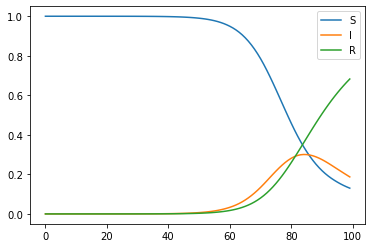

0.6993516185846691

In [13]:
def prob1():
    def ode(t,y):
        return np.array([-.5*y[0]*y[1], 
                         .5*y[0]*y[1]-(1/6)*y[1],
                         y[1]/6])
    
    # define the t0 and tf parameters
    t0 = 0
    tf = 50
    t_vals = np.linspace(t0, tf, 100)
    
    # define the initial conditions
    y0 = np.array([1-5/3e6,5/3e6,0])
    
    # solve the system
    sol = solve_ivp(ode, (t0,tf), y0, t_eval=t_vals)
    print('Peak infected proportion:', np.max(sol.y[1]))
    print('Lowest not-infected proportion:', 1-np.max(sol.y[1]))
    plt.plot(sol.y[0], label='S')
    plt.plot(sol.y[1], label='I')
    plt.plot(sol.y[2], label='R')
    plt.legend()
    plt.show()
    return 1-np.max(sol.y[1])
prob1()

# Problem 2

On March 11, 2020, New York City had 52 confirmed cases of Covid-19. On that day New York started its 
lock-down measures. Using the following information, model what the spread of the virus could have 
been if New York did not implement any measures to curb the spread of the virus over the next 150 days:
    there are approximately 8.399 million people in New York city,
    the average case of Covid-19 lasts for 10 days, 
    and each infected person can spread the virus to 2.5 people.

Plot your results for each day.

1) At the projected peak, how many concurrent active cases are there?

2) Assuming that about 5% of Covid-19 cases require hospitalization, and using the fact that there are 
about 58,000 hospital beds in NYC, how much over capacity will the hospitals in NYC be at the projected peak?

Peak infected proportion: 0.2342611672656666
Total infections: 1967560
Beds needed: 98378
Deficit: -40378


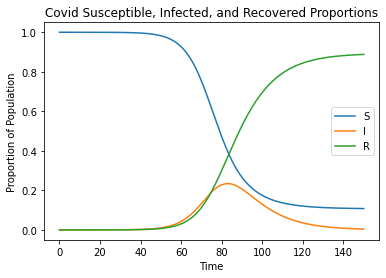

(1967560, -40378)

In [29]:
################################################################################
def prob2():
    '''
    Using the SIR model, plot a graph that models the
    spead of a disease in NYC and answer the questions.
    1. the projected peak concurent cases
    2. capacity deficit at the projected peak

    returns:
        ans1, ans2: answers to questions 1 and 2
    '''
    beta = .25
    gamma = 10
    def ode(t,y):
        return np.array([-1*beta*y[0]*y[1], 
                         beta * y[0] * y[1] - y[1] / gamma,
                         y[1]/gamma])
    
    # define the t0 and tf parameters
    t0 = 0
    tf = 150
    t_vals = np.linspace(t0, tf, 151)
    
    # define the initial conditions
    y0 = np.array([1-(52/8.399e6),52/8.399e6,0])
    
    # Solve the system
    sol = solve_ivp(ode, (t0,tf), y0, t_eval=t_vals)
    print('Peak infected proportion:', np.max(sol.y[1]))
    ans1 = round(np.max(sol.y[1]) * 8.399e6)
    print('Total infections:', ans1)
    
    beds_needed = round(.05*ans1)
    beds_available = 58000
    deficit = beds_available - beds_needed
    print('Beds needed:', beds_needed)
    print('Deficit:', deficit)
    
    # Graph SIR
    plt.title('Covid Susceptible, Infected, and Recovered Proportions')
    plt.xlabel('Time')
    plt.ylabel('Proportion of Population')
    plt.plot(sol.y[0], label='S')
    plt.plot(sol.y[1], label='I')
    plt.plot(sol.y[2], label='R')
    plt.legend()
    plt.show()
    
    return ans1, deficit
    
prob2()
################################################################################

# Problem 3

There are 7 billion people in the world. Suppose that influenza originates with 1000 people, and that they are contagious for 10 days before recovering.
Also suppose that on average someone makes one contact every two days that could spread the flu.
Since we can catch a new strain of the flu, suppose that a recovered individual becomes susceptible again with probability f=1/50. To assure a steady population, let the birth rate balance out the death rate, and in particular let μ=.0001.

Using the SIRS model above, plot the proportion of population that is Susceptible, Infected, and Recovered over a year span 365 days with one point for each day.

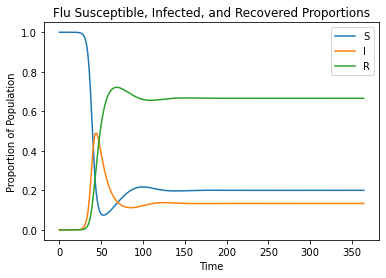

In [27]:
def prob3():
    '''
    Use the SIRS model to examine the spread of the 
    flu over the course of a year
    '''
    beta = .5
    gamma = 1/10
    N = 7e9
    f = 1/50
    mu = .0001
    
    def ode(t,y):
        return np.array([f*y[2] + mu*(1-y[0]) - beta*y[0]*y[1], 
                         beta * y[0] * y[1] - (gamma + mu) * y[1],
                         -1*f*y[2] + gamma*y[1] - mu*y[2]])
    
    # define the t0 and tf parameters
    t0 = 0
    tf = 365
    t_vals = np.linspace(t0, tf, 365)
    
    # define the initial conditions
    y0 = np.array([1-(1000/N),1000/N,0])
    
    # Solve the system
    sol = solve_ivp(ode, (t0,tf), y0, t_eval=t_vals)

    # Graph SIR
    plt.title('Flu Susceptible, Infected, and Recovered Proportions')
    plt.xlabel('Time')
    plt.ylabel('Proportion of Population')
    plt.plot(sol.y[0], label='S')
    plt.plot(sol.y[1], label='I')
    plt.plot(sol.y[2], label='R')
    plt.legend()
    plt.show()
    
prob3()
################################################################################

# Problem 4

Fit the PGED model to the Covid-19 data provided in new_york_cases.npy.
Print the optimal values of alpha and T_G, and plot your results against 1-S(t).
Use one point for each day.

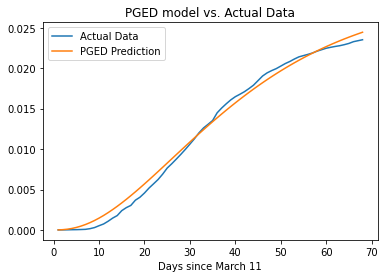

In [62]:
def prob4():
    
    data = np.load('new_york_cases.npy')/8.399e6
    t0 = 1
    tf = 68
    t_span = np.linspace(t0, tf, 68)
    
    y0 = np.array([1-(52/8.399e6),52/8.399e6,0])
    
    def ode(t, y, alpha, Tg):
            return np.array([(-1*alpha/t)*y[1],
                             ((alpha/t) - (1/Tg))*y[1],
                             (1/Tg)*y[1]])
        
    # define the function we want to minimize
    def fun(params):
        alpha, Tg = params
        sol = solve_ivp(ode, (t0,tf), y0, args=(alpha,Tg), t_eval=t_span)
        return np.linalg.norm((1-sol.y[0]) - data) #should be 0
    
    p0 = np.array([2,23])
    _min = minimize(fun,p0)
    sol = solve_ivp(ode, (t0,tf), y0, args=(_min.x[0],_min.x[1]), t_eval=t_span)
    
    plt.title('PGED model vs. Actual Data')
    plt.plot(t_span, data, label='Actual Data')
    plt.plot(t_span, 1-sol.y[0], label='PGED Prediction')
    plt.xlabel('Days since March 11')
    plt.legend()
    plt.show()
prob4()



# Problem 5

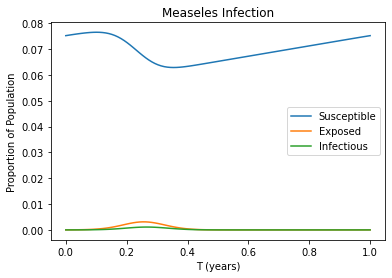

In [17]:
def prob5():
    '''
    Use solve_bvp to model the measles boundary value
    problem
    '''
    B1 = 1
    B0 = 1575
    eta = 0.01
    lam = 0.0279
    mu = .02
    beta = lambda t: B0 * (1 + B1 * np.cos(2*np.pi*t))
    
    def ode(t, y):
        return np.array([mu - (beta(t) * y[0] * y[2]),
                        (beta(t) * y[0] * y[2]) - y[1]/lam,
                        y[1]/lam - y[2]/eta,
                        np.zeros(len(t)),
                        np.zeros(len(t)),
                        np.zeros(len(t))]) 
    
    def bcs(ya, yb):
        bcl = ya[0:3] - ya[3:]    # Boundary condition on left
        bcr = yb[0:3] - yb[3:]    # Boundary condition on right
        return np.hstack([bcl, bcr])
    
    t0 = 0
    tf = 1
    t_span = np.linspace(t0,tf,100)
    
    y = np.array([1, 0, .9, 0, 0, 0]).reshape((-1,1))*np.ones(len(t_span))
    
    solution = solve_bvp(ode, bcs, t_span, y)
    y1_plot = solution.sol(t_span)[0]
    plt.plot(t_span, y1_plot, label='Susceptible')
    y2_plot = solution.sol(t_span)[1]
    plt.plot(t_span, y2_plot, label='Exposed')
    y3_plot = solution.sol(t_span)[2]
    plt.plot(t_span, y3_plot, label='Infectious')
    plt.xlabel('T (years)')
    plt.ylabel('Proportion of Population')
    plt.title('Measeles Infection')
    plt.legend()
    plt.show()
prob5()